# Option 1: Sentiment Identification
### BACKGROUND
A large multinational corporation is seeking to automatically identify the sentiment that their customer base talks about on social media. They would like to expand this capability into multiple languages. Many 3rd party tools exist for sentiment analysis, however, they need help with under-resourced languages.
### GOAL
Train a sentiment classifier (Positive, Negative, Neutral) on a corpus of the provided documents. Your goal is to maximize accuracy. There is special interest in being able to accurately detect negative sentiment. The training data includes documents from a wide variety of sources, not merely social media, and some of it may be inconsistently labeled. Please describe the business outcomes in your work sample including how data limitations impact your results and how these limitations could be addressed in a larger project.
### DATA
Link to data: http://archive.ics.uci.edu/ml/datasets/Roman+Urdu+Data+Set

In [138]:
import pandas as pd
import numpy as np
import re
import string

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import (precision_score, 
                             recall_score,
                             f1_score,
                             accuracy_score,
                             confusion_matrix,
                             roc_auc_score,
                             roc_curve)


from collections import Counter

import nltk
nltk.download('punkt')

from gensim.models import Phrases
from gensim.models.phrases import Phraser

import matplotlib.pyplot as plt
%matplotlib inline

[nltk_data] Downloading package punkt to /home/ubuntu/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


### Import the data and do initial cleaning

In [139]:
df = pd.read_csv('data/Roman Urdu DataSet.csv',skipinitialspace=True, header=None,names=['text','sentiment','del'])
with open('data/roman-urdu-stopwords') as f:
    stop_words = f.read()
    stop_words = stop_words.split('\n')
with open('data/roman-urdu-properNouns') as f:
    proper_nouns = f.read()
    proper_nouns = [word.lower() for word in proper_nouns.split('\n')]
df.drop('del',axis=1,inplace=True)

In [140]:
df.groupby('sentiment').size()

sentiment
Neative        1
Negative    5286
Neutral     8929
Positive    6013
dtype: int64

In [141]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20229 entries, 0 to 20228
Data columns (total 2 columns):
text         20116 non-null object
sentiment    20229 non-null object
dtypes: object(2)
memory usage: 316.2+ KB


Replace with correct spelling, drop missing text values

In [142]:
df['sentiment'].replace('Neative','Negative', inplace=True)
df = df.dropna(axis=0,subset=['text'])
df.groupby('sentiment').size()

sentiment
Negative    5287
Neutral     8816
Positive    6013
dtype: int64

In [143]:
df.head()

,text,sentiment
0,Sai kha ya her kisi kay bus ki bat nhi hai lak...,Positive
1,sahi bt h,Positive
2,"Kya bt hai,",Positive
3,Wah je wah,Positive
4,Are wha kaya bat hai,Positive


### Create function for tokenizing words.. make all lowercase, remove numeric data, symbols and punction
#### Transform corpus into a list of list of tokens. Create bi/tri-grams with Gensim's phraser function

In [144]:
def tokenize(doc):
    '''Tokenize a single document'''
    tokens = [word.lower() for word in nltk.word_tokenize(doc) if len(word) > 1]
    tokens = [re.sub(r'[0-9 \n\.]','',word) for word in tokens]
    tokens = [re.sub(r'['+string.punctuation+']', '',word) for word in tokens]
    tokens = [word for word in tokens if not word in stop_words and word not in proper_nouns]
    return tokens

def tokenize_corpus(content, n_grams=3):
    '''transform a list of documents to a tokenized corpus with n_grams'''
    
    print('# docs in corpus: {}'.format( len(content)))
    
    #Convert to tokenized documents
    tokenized_corp=[]
    for doc in content:
        tokenized_corp.append(tokenize(doc))
    
    #Add n_grams
    bigram = Phrases(tokenized_corp, min_count=5, threshold=10)
    trigram = Phrases(bigram[tokenized_corp], threshold=10)
    bigram_mod = Phraser(bigram)
    trigram_mod = Phraser(trigram)
    
    if n_grams > 1:
        for i, doc in enumerate(tokenized_corp):
            tokenized_corp[i] = bigram_mod[doc]
            if n_grams > 2: 
                tokenized_corp[i] = trigram_mod[bigram_mod[doc]]
    
    return tokenized_corp

In [145]:
content = df['text'].tolist()
tokenized_corp = tokenize_corpus(content,n_grams=3)

# docs in corpus: 20116


Create X and y.. Flatten X into 1D numpy array. Convert class labels to -1, 0, 1 where:
 * -1 is 'Positive"
 * 0 is 'Neutral'
 * 1 is Negative
 
>Note: might seem counter intuitive making the 'Negative' label '1', but 'Negative' sentiment is the label we're looking to detect and measure for recall and precision

In [146]:
y = df['sentiment'].copy().values
np.place(y,y == 'Negative',-1)
np.place(y,y == 'Positive',1)
np.place(y,y == 'Neutral',0)
y = y.astype(int)
X = np.array([' '.join(doc) for doc in tokenized_corp])

Sanity check vocabulary if needed to check for bad tokens...

In [147]:
c = CountVectorizer()
X_count = c.fit_transform(X)
sorted(c.vocabulary_.keys())

['aa',
 'aa_gaey',
 'aaa',
 'aaaa',
 'aaaaa',
 'aaaaappppp',
 'aaaallaaaa',
 'aaaallllaaaa',
 'aaah',
 'aaaiin',
 'aaainda',
 'aaalam',
 'aaalu',
 'aaankh',
 'aaao',
 'aaap',
 'aaatma',
 'aaaya',
 'aab',
 'aaba',
 'aabaadi',
 'aabaai',
 'aabad',
 'aabai',
 'aabao',
 'aabbba',
 'aabi',
 'aabroz',
 'aachay',
 'aachi',
 'aachuki',
 'aad',
 'aada',
 'aadaa',
 'aadam',
 'aadat',
 'aadha',
 'aadhay',
 'aadhi',
 'aadi',
 'aadmi',
 'aadmiyon',
 'aadmy',
 'aae',
 'aaeen',
 'aaega',
 'aaegi',
 'aaein',
 'aaey',
 'aaeyn',
 'aafaaq',
 'aafaq',
 'aafia',
 'aafiat',
 'aafiyat',
 'aafreeni',
 'aafrini',
 'aaftab',
 'aafza',
 'aag',
 'aaga',
 'aagae',
 'aagah',
 'aagahi',
 'aagai',
 'aagash',
 'aagay',
 'aagaya',
 'aagaye',
 'aagayen',
 'aagaz',
 'aage',
 'aaghaz',
 'aaghaz_kiya',
 'aaghosh',
 'aagly',
 'aagrah',
 'aagy',
 'aagye',
 'aah',
 'aahang',
 'aahata',
 'aahhahahaha',
 'aahinda',
 'aahinkhair',
 'aahista',
 'aahkoon',
 'aahyan',
 'aai',
 'aaid',
 'aaiga',
 'aaigi',
 'aain',
 'aaina',
 'aainda

### TFI-IDF vectorization to tranform tokens into numerical values. Fit to the data and optimize hyperparameters through repeated cross validation

Note: An exhaustive gridsearch can also be utilized here to find the best hyperparams

In [148]:
vectorizer = TfidfVectorizer(max_df=0.65,
                             binary=False,
                             sublinear_tf=True,
                             use_idf=True) 

### Train and cross-validate a Naive Bayes classifier. Optimize alpha smoothing

In [149]:
skf = StratifiedKFold(n_splits=20,shuffle=True)
clf = MultinomialNB(alpha=0.25)
scores = []

In [150]:
for train_index, test_index in skf.split(X, y):
    print("TRAIN:", train_index, "TEST:", test_index)
    print("TRAIN size:", train_index.shape[0], "TEST size:", test_index.shape[0])
    X_train, y_train, X_test, y_test = X[train_index], y[train_index], X[test_index], y[test_index]
    
    #Vectorize the training values
    tf_idf = vectorizer.fit_transform(X_train)
    
    #Fit the classifier to training data
    clf = clf.fit(tf_idf,y_train) 

    #Vectorize the test values
    X_test_tfidf = vectorizer.transform(X_test) 
    
    #Predict on test values
    y_pred = clf.predict(X_test_tfidf)
    y_pred_proba = clf.predict_proba(X_test_tfidf)
    
    #Print out scores for this fold
    score = clf.score(X_test_tfidf,y_test)
    print('Score: {:2.4f}'.format(score))
    scores.append(score)
    
#Print average score
print('Average Accuracy: {:2.4f}'.format(np.mean(scores)))

TRAIN: [    0     1     2 ... 20112 20113 20114] TEST: [   52    57    68 ... 20081 20088 20115]
TRAIN size: 19109 TEST size: 1007
Score: 0.6296
TRAIN: [    0     1     2 ... 20113 20114 20115] TEST: [   15    23    45 ... 20075 20094 20101]
TRAIN size: 19109 TEST size: 1007
Score: 0.6385
TRAIN: [    0     1     3 ... 20112 20113 20115] TEST: [    2    10    16 ... 20092 20093 20114]
TRAIN size: 19109 TEST size: 1007
Score: 0.6276
TRAIN: [    0     1     2 ... 20113 20114 20115] TEST: [    5     7    12 ... 20018 20063 20095]
TRAIN size: 19109 TEST size: 1007
Score: 0.6663
TRAIN: [    0     2     3 ... 20113 20114 20115] TEST: [    1    19    20 ... 20068 20084 20108]
TRAIN size: 19109 TEST size: 1007
Score: 0.6425
TRAIN: [    0     1     2 ... 20113 20114 20115] TEST: [   30   102   106 ... 20076 20078 20090]
TRAIN size: 19109 TEST size: 1007
Score: 0.6226
TRAIN: [    0     1     2 ... 20112 20114 20115] TEST: [    8    14    33 ... 20069 20086 20113]
TRAIN size: 19109 TEST size: 1007

In [151]:
from sklearn.utils.multiclass import unique_labels

def plot_confusion_matrix(ax, y_true, y_pred, classes,normalize=False,title=None,cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
#     classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

Confusion matrix, without normalization
Normalized confusion matrix


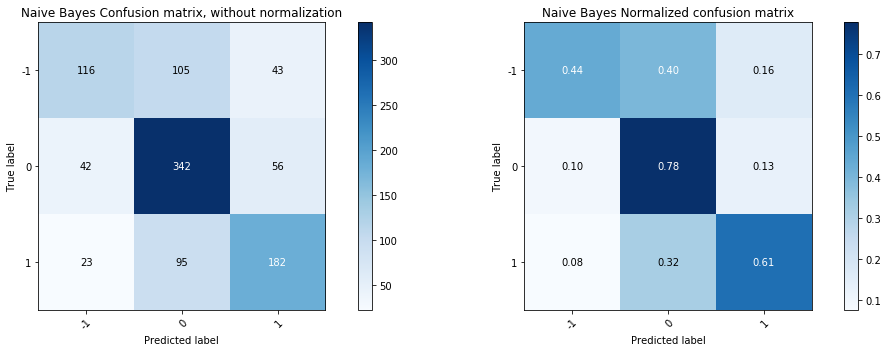

In [152]:
fig, axs = plt.subplots(1,2,figsize=(16,5))
class_names=np.array(['-1', '0', '1'])

# Plot non-normalized confusion matrix
axs[0] = plot_confusion_matrix(axs[0],y_test, y_pred, classes=class_names,
                      title='Naive Bayes Confusion matrix, without normalization')

# Plot normalized confusion matrix
axs[1] = plot_confusion_matrix(axs[1],y_test, y_pred, classes=class_names, normalize=True,
                      title='Naive Bayes Normalized confusion matrix')

>Better than classifying at random, but our ability to detect negative values is very poor. Lets see if we can improve

### Alt Scenario 1: Train a classifier on more polarized data by dropping the 'Neutral' values

In [153]:
df_no_neutral = df[df['sentiment'] != 'Neutral']
df_no_neutral.groupby('sentiment').size()

sentiment
Negative    5287
Positive    6013
dtype: int64

In [154]:
content_no_neutral = df_no_neutral['text'].tolist()
tokenized_corp_no_neutral = tokenize_corpus(content_no_neutral,n_grams=3)

# docs in corpus: 11300


In [155]:
y = df_no_neutral['sentiment'].copy().values
np.place(y,y == 'Negative',1)
np.place(y,y == 'Positive',0)
y = y.astype(int)
X = np.array([' '.join(doc) for doc in tokenized_corp_no_neutral])

In [156]:
vectorizer = TfidfVectorizer(max_df=0.65,
                             lowercase=False,
                             norm = 'l2',
                             sublinear_tf=True,
                             use_idf=False)

###  Since were using only two binary classes, we can use measure our results with Recall and Precision values to to see how well we're able to classify 'Negative' sentiment 

In [157]:
skf = StratifiedKFold(n_splits=3,shuffle=True)
clf = MultinomialNB(alpha=0.4)
acc_scores = []
rec_scores = []
prec_scores = []
f1_scores = []
roc_scores = []

In [158]:
for train_index, test_index in skf.split(X, y):
    print("TRAIN:", train_index, "TEST:", test_index)
    print("TRAIN size:", train_index.shape[0], "TEST size:", test_index.shape[0])
    X_train, y_train, X_test, y_test = X[train_index], y[train_index], X[test_index], y[test_index]
    
    #Vectorize the training values
    tf_idf = vectorizer.fit_transform(X_train)
    
    #Fit the classifier to training data
    clf = clf.fit(tf_idf,y_train)    
    
    #Vectorize the test values
    X_test_tfidf = vectorizer.transform(X_test)
    
    #Predict on test values
    y_pred = clf.predict(X_test_tfidf)
    y_pred_proba = clf.predict_proba(X_test_tfidf)
    
    #Print out scores for this fold
    acc_scores.append(clf.score(X_test_tfidf,y_test))
    rec_scores.append(recall_score(y_test,y_pred))
    prec_scores.append(precision_score(y_test,y_pred))
    f1_scores.append(f1_score(y_test,y_pred))
    roc_scores.append(roc_auc_score(y_test,y_pred_proba[:,1]))
    
    print('Accuracy Score: {:2.4f}'.format(acc_scores[-1]))
    print(' -- recall score:  {:2.4f}'.format(rec_scores[-1]))
    print(' -- precision score:  {:2.4f}'.format(prec_scores[-1]))
    print(' -- f1 score:  {:2.4f}'.format(f1_scores[-1]))
    print(' -- roc_auc score:  {:2.4f}'.format(roc_scores[-1]))

print('\nAverage Accuracy: {:2.4f}'.format(np.mean(acc_scores)))
print(' -- Average recall score:  {:2.4f}'.format(np.mean(rec_scores)))
print(' -- Average precision score:  {:2.4f}'.format(np.mean(prec_scores)))
print(' -- Average f1 score:  {:2.4f}'.format(np.mean(f1_scores)))
print(' -- Average roc_auc score:  {:2.4f}'.format(np.mean(roc_scores)))

TRAIN: [    0     1     2 ... 11295 11296 11299] TEST: [    6     9    12 ... 11292 11297 11298]
TRAIN size: 7532 TEST size: 3768
Accuracy Score: 0.7779
 -- recall score:  0.7096
 -- precision score:  0.7938
 -- f1 score:  0.7493
 -- roc_auc score:  0.8613
TRAIN: [    1     3     5 ... 11297 11298 11299] TEST: [    0     2     4 ... 11290 11294 11296]
TRAIN size: 7534 TEST size: 3766
Accuracy Score: 0.7796
 -- recall score:  0.7225
 -- precision score:  0.7887
 -- f1 score:  0.7541
 -- roc_auc score:  0.8669
TRAIN: [    0     2     4 ... 11296 11297 11298] TEST: [    1     3     5 ... 11293 11295 11299]
TRAIN size: 7534 TEST size: 3766
Accuracy Score: 0.7751
 -- recall score:  0.7100
 -- precision score:  0.7883
 -- f1 score:  0.7471
 -- roc_auc score:  0.8654

Average Accuracy: 0.7775
 -- Average recall score:  0.7140
 -- Average precision score:  0.7903
 -- Average f1 score:  0.7502
 -- Average roc_auc score:  0.8645


>The Classifier seems to perform much better when the sentiment has less noise from the Neutrals.. 

#### ROC Curve: 

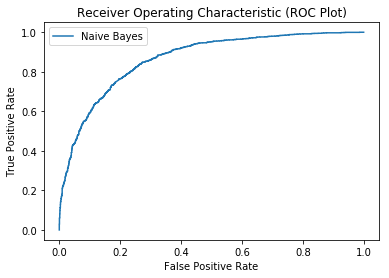

In [159]:
fig, ax = plt.subplots(figsize=(6,4))
fpr, tpr, thresholds = roc_curve(y_test,y_pred_proba[:,1])
ax.plot(fpr,tpr,label='Naive Bayes')

# ax.plot([0,1],[0,1],color='gray',label='random classification')
ax.set_title('Receiver Operating Characteristic (ROC Plot)')
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate');
ax.legend();

>The results look great but it's a bit missleading since the real data we'd like to test this model with will have Neutral values that could get missclassified. Still, if all we're worried about is detecting negative sentiment and don't care about false alarms.. we have a solid Recall Score

### Alt Scenario 2: Since the classifier will be making predictions on neutral sentiments, its best to keep the neutral data while training... Let's make our classes binary but convert Neutrals to the same class as Positive  since we want to ultimately detect Negative sentiment

In [160]:
y = df['sentiment'].copy().values
np.place(y,y == 'Negative',1)
np.place(y,y == 'Positive',0)
np.place(y,y == 'Neutral',0)
y = y.astype(int)
X = np.array([' '.join(doc) for doc in tokenized_corp])

In [161]:
vectorizer = TfidfVectorizer(max_df=0.75,
                             lowercase=False,
                             norm = 'l2',
                             sublinear_tf=True,
                             use_idf=False)

#### The issue is, the data is now moderately imbalanced, which may cause our classifier to become bias towards the negative ('Positive' and 'Neutral' sentiment) class

In [162]:
np.bincount(y)

array([14829,  5287])

#### To combat this, we'll use an algoritm called SMOTE to generate synthetic data within (and only within) the minority TRAINING set after each K-Fold and before each classifier fit / predict on test data

In [170]:
from imblearn.over_sampling import SMOTE
sm = SMOTE(sampling_strategy=1.0,
           random_state=5,
           k_neighbors=3)

In [171]:
skf = StratifiedKFold(n_splits=3,shuffle=True)
clf = MultinomialNB(alpha=0.25)

acc_scores_sm = []
rec_scores_sm = []
prec_scores_sm = []
f1_scores_sm = []
roc_scores_sm = []

In [172]:
from sklearn.preprocessing import MaxAbsScaler

for train_index, test_index in skf.split(X, y):
    print("TRAIN:", train_index, "TEST:", test_index)
    print("TRAIN size:", train_index.shape[0], "TEST size:", test_index.shape[0])
    X_train, y_train, X_test, y_test_sm = X[train_index], y[train_index], X[test_index], y[test_index]

    print(' -- Positive % balance: {:2.4f}'.format(Counter(y_test_sm)[1]/y_test_sm.shape[0]))
    
    #Vectorize the training values
    tf_idf = vectorizer.fit_transform(X_train)
    
   #Scale data if needed for kNN 
    scaler = MaxAbsScaler()
    tf_idf = scaler.fit_transform(tf_idf)
    
    #Use SMOTE to re-balance the data by synthetically over-sampling the minority:
    print('original y_train positive counts: {}'.format(y_train[y_train == 1].shape[0]) )
    tf_idf_sm, y_train_sm = sm.fit_sample(tf_idf, y_train)
    print('new y_train positive counts after rebalancing: {}'.format(y_train_sm[y_train_sm == 1].shape[0]))
    
    #Fit the classifier to training data
    clf = clf.fit(tf_idf_sm,y_train_sm)    
    
    #Vectorize the test values
    X_test_tfidf_sm = vectorizer.transform(X_test)
    
    #Predict on test values
    y_pred_sm = clf.predict(X_test_tfidf_sm)
    y_pred_proba_sm = clf.predict_proba(X_test_tfidf_sm)
    
    #Print out scores for this fold
    acc_scores_sm.append(clf.score(X_test_tfidf_sm,y_test_sm))
    rec_scores_sm.append(recall_score(y_test_sm,y_pred_sm))
    prec_scores_sm.append(precision_score(y_test_sm,y_pred_sm))
    f1_scores_sm.append(f1_score(y_test_sm,y_pred_sm))
    roc_scores_sm.append(roc_auc_score(y_test_sm,y_pred_proba_sm[:,1]))
    
    print(' -- Accuracy Score: {:2.4f}'.format(acc_scores_sm[-1]))
    print('   -- recall score:  {:2.4f}'.format(rec_scores_sm[-1]))
    print('   -- precision score:  {:2.4f}'.format(prec_scores_sm[-1]))
    print('   -- f1 score:  {:2.4f}'.format(f1_scores_sm[-1]))
    print('   -- roc_auc score:  {:2.4f}'.format(roc_scores_sm[-1]))

print('\nAverage Accuracy: {:2.4f}'.format(np.mean(acc_scores_sm)))
print(' -- Average recall score:  {:2.4f}'.format(np.mean(rec_scores_sm)))
print(' -- Average precision score:  {:2.4f}'.format(np.mean(prec_scores_sm)))
print(' -- Average f1 score:  {:2.4f}'.format(np.mean(f1_scores_sm)))
print(' -- Average roc_auc score:  {:2.4f}'.format(np.mean(roc_scores_sm)))

TRAIN: [    0     1     3 ... 20110 20111 20115] TEST: [    2     5     7 ... 20112 20113 20114]
TRAIN size: 13410 TEST size: 6706
 -- Positive % balance: 0.2629
original y_train positive counts: 3524
new y_train positive counts after rebalancing: 9886
 -- Accuracy Score: 0.7419
   -- recall score:  0.6591
   -- precision score:  0.5070
   -- f1 score:  0.5731
   -- roc_auc score:  0.7971
TRAIN: [    2     5     7 ... 20112 20113 20114] TEST: [    0     1     3 ... 20109 20110 20115]
TRAIN size: 13411 TEST size: 6705
 -- Positive % balance: 0.2628
original y_train positive counts: 3525
new y_train positive counts after rebalancing: 9886
 -- Accuracy Score: 0.7424
   -- recall score:  0.6720
   -- precision score:  0.5075
   -- f1 score:  0.5783
   -- roc_auc score:  0.7926
TRAIN: [    0     1     2 ... 20113 20114 20115] TEST: [    8    11    12 ... 20103 20106 20111]
TRAIN size: 13411 TEST size: 6705
 -- Positive % balance: 0.2628
original y_train positive counts: 3525
new y_train pos

>Here, our recall score has improved, but precision is suffering.. meaning our classifier is making a lot of false positives (misclassifying truly Positive sentiment as negative). For our case, Recall is more important here

Confusion matrix, without normalization
Normalized confusion matrix


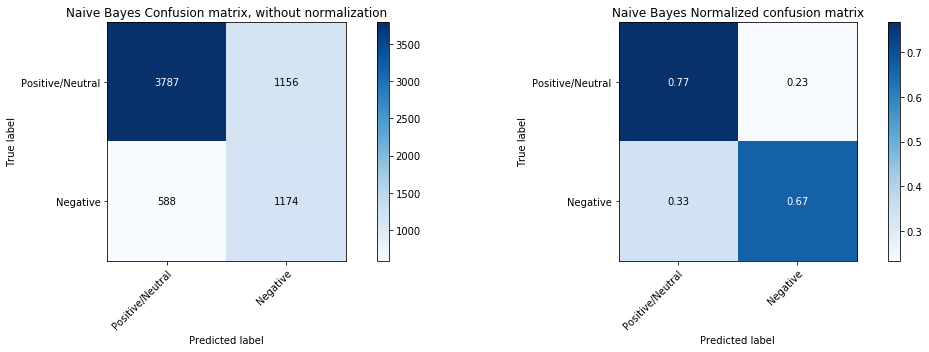

In [173]:
class_names = np.array(['Positive/Neutral', 'Negative'])

fig, axs = plt.subplots(1,2,figsize=(16,5))

# Plot non-normalized confusion matrix
axs[0] = plot_confusion_matrix(axs[0],y_test_sm, y_pred_sm, classes=class_names,
                      title='Naive Bayes Confusion matrix, without normalization')

# Plot normalized confusion matrix
axs[1] = plot_confusion_matrix(axs[1],y_test_sm, y_pred_sm, classes=class_names, normalize=True,
                      title='Naive Bayes Normalized confusion matrix')

### Note that without SMOTE, our recall score would not be very good, meaning we would MISS negative sentiment classes. That's bad!

Binary classifier with Neutral values and without SMOTE:

In [167]:
acc_scores = []
rec_scores = []
prec_scores = []
f1_scores = []
roc_scores = []

for train_index, test_index in skf.split(X, y):
    print("TRAIN:", train_index, "TEST:", test_index)
    print("TRAIN size:", train_index.shape[0], "TEST size:", test_index.shape[0])
    X_train, y_train, X_test, y_test = X[train_index], y[train_index], X[test_index], y[test_index]

    #Vectorize the X Training data
    tf_idf = vectorizer.fit_transform(X_train)
    
    #Fit the classifier to the training data
    clf = clf.fit(tf_idf,y_train)    
    
    #Vectorize the test values
    X_test_tfidf = vectorizer.transform(X_test)
    
    #Predict on test values
    y_pred = clf.predict(X_test_tfidf)
    y_pred_proba = clf.predict_proba(X_test_tfidf)
    
    #Print out scores for this fold
    acc_scores.append(clf.score(X_test_tfidf,y_test))
    rec_scores.append(recall_score(y_test,y_pred))
    prec_scores.append(precision_score(y_test,y_pred))
    f1_scores.append(f1_score(y_test,y_pred))
    roc_scores.append(roc_auc_score(y_test,y_pred_proba[:,1]))
    
    print('Accuracy Score: {:2.4f}'.format(acc_scores[-1]))
    print(' -- recall score:  {:2.4f}'.format(rec_scores[-1]))
    print(' -- precision score:  {:2.4f}'.format(prec_scores[-1]))
    print(' -- f1 score:  {:2.4f}'.format(f1_scores[-1]))
    print(' -- roc_auc score:  {:2.4f}'.format(roc_scores[-1]))

print('\nAverage Accuracy: {:2.4f}'.format(np.mean(acc_scores)))
print(' -- Average recall score:  {:2.4f}'.format(np.mean(rec_scores)))
print(' -- Average precision score:  {:2.4f}'.format(np.mean(prec_scores)))
print(' -- Average f1 score:  {:2.4f}'.format(np.mean(f1_scores)))
print(' -- Average roc_auc score:  {:2.4f}'.format(np.mean(roc_scores)))

TRAIN: [    0     2     4 ... 20113 20114 20115] TEST: [    1     3     7 ... 20103 20104 20108]
TRAIN size: 13410 TEST size: 6706
Accuracy Score: 0.7823
 -- recall score:  0.2490
 -- precision score:  0.7635
 -- f1 score:  0.3755
 -- roc_auc score:  0.7869
TRAIN: [    0     1     2 ... 20109 20112 20115] TEST: [    4    14    16 ... 20111 20113 20114]
TRAIN size: 13411 TEST size: 6705
Accuracy Score: 0.7872
 -- recall score:  0.2582
 -- precision score:  0.7913
 -- f1 score:  0.3894
 -- roc_auc score:  0.7871
TRAIN: [    1     3     4 ... 20111 20113 20114] TEST: [    0     2     5 ... 20109 20112 20115]
TRAIN size: 13411 TEST size: 6705
Accuracy Score: 0.7897
 -- recall score:  0.2628
 -- precision score:  0.8066
 -- f1 score:  0.3964
 -- roc_auc score:  0.8061

Average Accuracy: 0.7864
 -- Average recall score:  0.2567
 -- Average precision score:  0.7871
 -- Average f1 score:  0.3871
 -- Average roc_auc score:  0.7934


>Oddly enough the accuracy is higher without SMOTE and precision out-performs. If you were to put the two ROC curves next to each other they'd look nearly identical. But the recall score is very poor. Its assumed we only properly detect ~25% of negative sentiment.. not good!

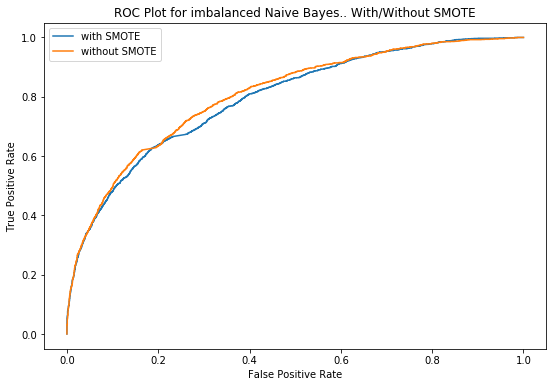

In [174]:
fig, ax = plt.subplots(figsize=(9,6))
fpr, tpr, thresholds = roc_curve(y_test_sm,y_pred_proba_sm[:,1])
ax.plot(fpr,tpr,label='with SMOTE')
fpr, tpr, thresholds = roc_curve(y_test,y_pred_proba[:,1])
ax.plot(fpr,tpr,label='without SMOTE')

# ax.plot([0,1],[0,1],color='gray',label='random classification')
ax.set_title('ROC Plot for imbalanced Naive Bayes.. With/Without SMOTE')
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate');
ax.legend();

#### Comparing Normalized confusion matrices, with and without SMOTE

Normalized confusion matrix
Normalized confusion matrix


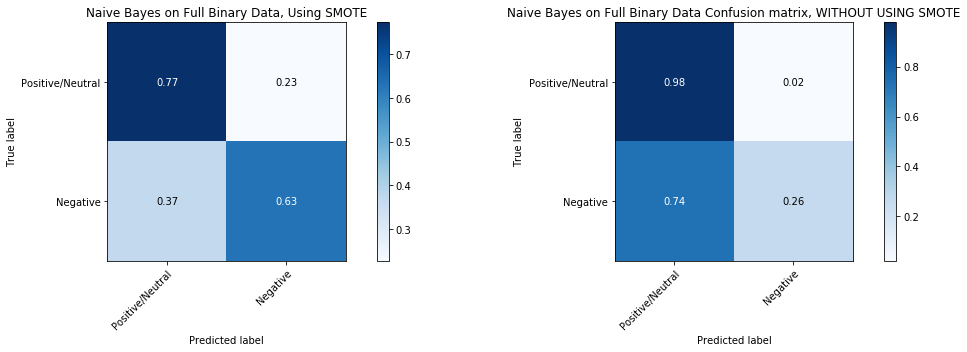

In [169]:
fig, axs = plt.subplots(1,2,figsize=(16,5))

# Plot normalized confusion matrix
axs[0] = plot_confusion_matrix(axs[0],y_test_sm, y_pred_sm, classes=class_names, normalize=True,
                      title='Naive Bayes on Full Binary Data, Using SMOTE')

# Plot non-normalized confusion matrix
axs[1] = plot_confusion_matrix(axs[1],y_test, y_pred, classes=class_names,normalize=True,
                      title='Naive Bayes on Full Binary Data Confusion matrix, WITHOUT USING SMOTE')

### This Section is for Grid Search CV
##### NOTE: DO NOT run this unless optimizing hyperparameters.. will take some time to run

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

mnb_pipeline = Pipeline([
    ('tfidf_vectorizer', TfidfVectorizer()),
    ('mnb', MultinomialNB())
])


grid_params = {
  'mnb__alpha': np.linspace(0.2, 0.5, 6),
  'mnb__fit_prior': [True, False],
  'tfidf_vectorizer__max_df': [0.6,0.65,0.7,0.75],
  'tfidf_vectorizer__binary': [True, False],
  'tfidf_vectorizer__sublinear_tf': [True,False]
}

gs = GridSearchCV(mnb_pipeline, grid_params, scoring = 'accuracy',cv = 3,n_jobs=-1,verbose=4)
gs.fit(X, y)

In [ ]:
print("Best Score: ", gs.best_score_)
print("Best Params: ", gs.best_params_)